In [1]:
import sys
import os
import logging

import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines # importance ranking
import seaborn as sns
import shap

%matplotlib inline

from BDT import (
    read_data,
    read_features,
    prepare_test_data,
    prepare_test_data_matrix,
    prepare_data_matrix,
)
shap.initjs()

In [2]:
# load data and model
SPLIT_FRACTION = 0.5
data = read_data("./input/")
feature_names = read_features(data)
data_test = prepare_test_data(data, SPLIT_FRACTION)
test_data_matrix = prepare_test_data_matrix(data_test, feature_names)

X = data[feature_names]

booster = xgb.Booster()
booster.load_model("./output/booster.bin")
booster.feature_names = feature_names # save_model does not save feature names
booster.feature_types = ['float' for x in range(len(feature_names))]

In [3]:
# calculate shap values
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X)

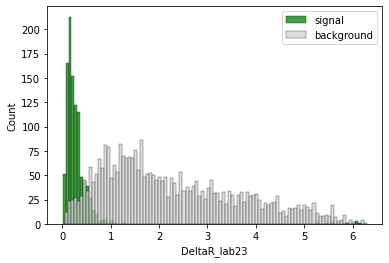

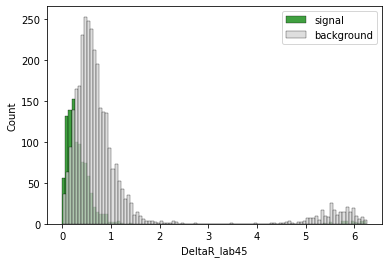

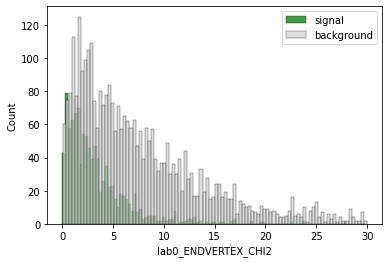

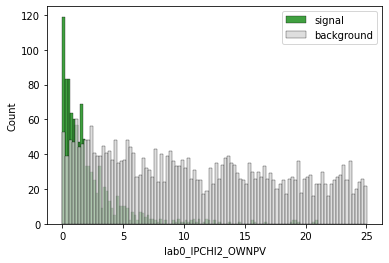

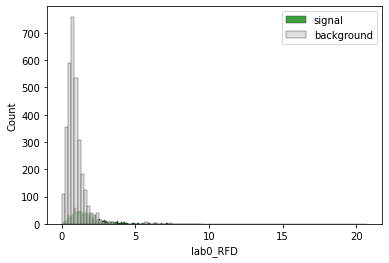

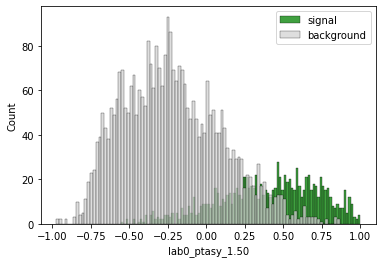

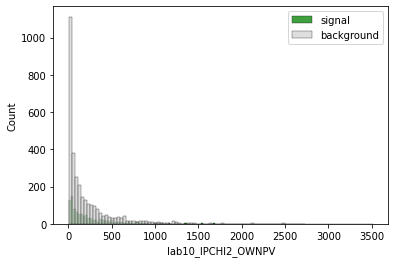

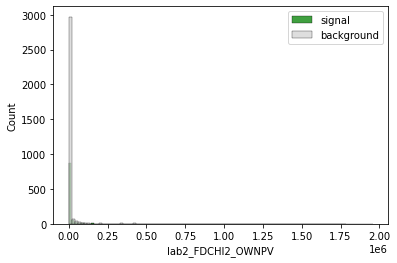

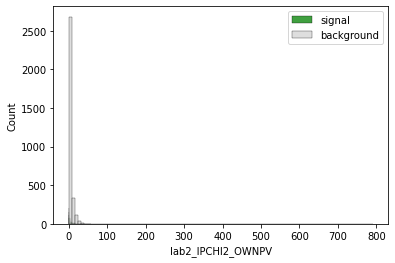

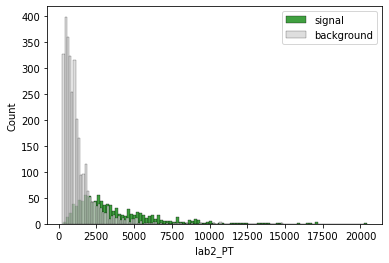

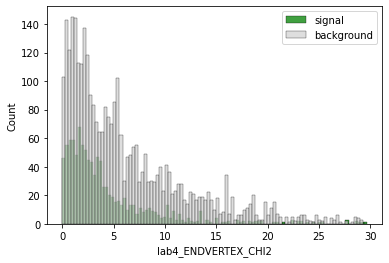

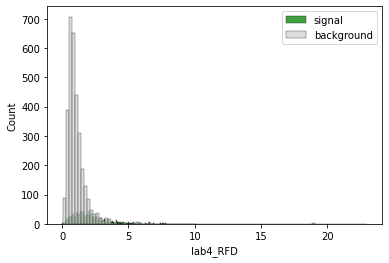

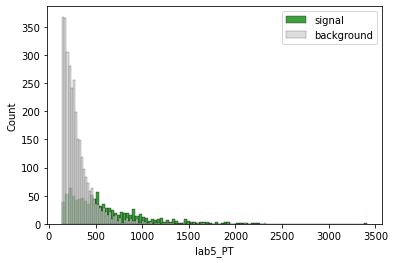

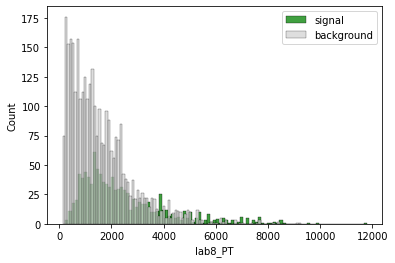

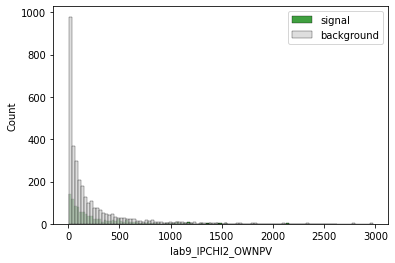

In [4]:
# Plot classification by feature
float_predictions = booster.predict(test_data_matrix).tolist()
predictions = list(map(round, float_predictions))
for feature_name in data_test[feature_names]:
    feature = pd.DataFrame(data_test[feature_name])
    feature.insert(1, "prediction", predictions, True)
    signal = feature[feature["prediction"] == 1]
    background = feature[feature["prediction"] == 0]
    
    plt.figure()
    sns.histplot(signal[feature_name], bins=100, color="green", label="signal")
    sns.histplot(background[feature_name], bins=100, color="lightgray", label="background")
    plt.legend()


In [5]:
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

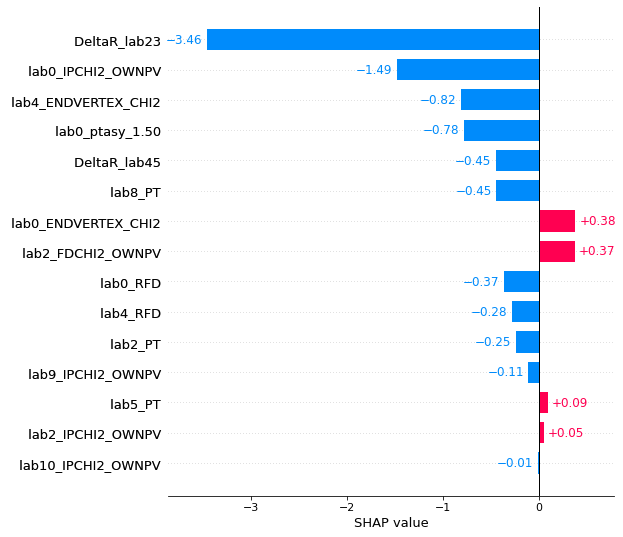

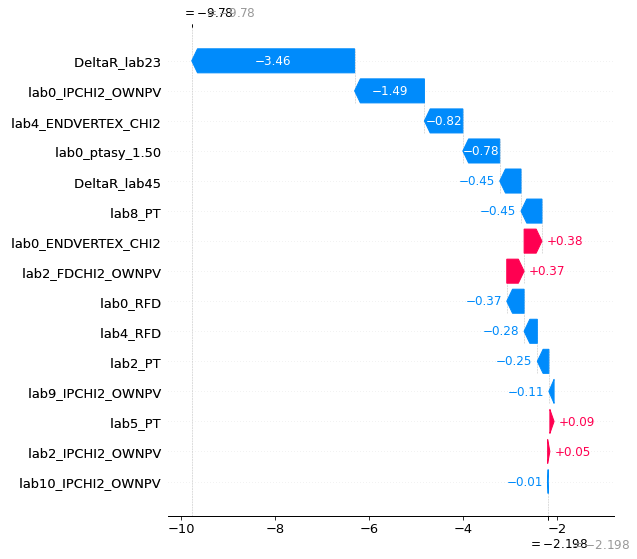

In [6]:
shap.plots.bar(explainer(X)[0], max_display=20)
shap.waterfall_plot(explainer(X)[0], max_display=20)

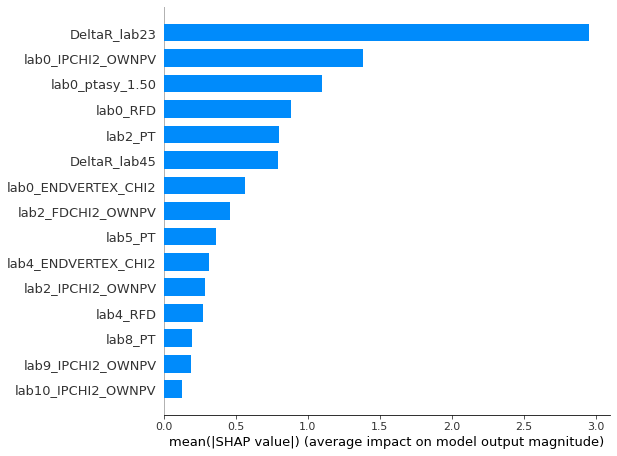

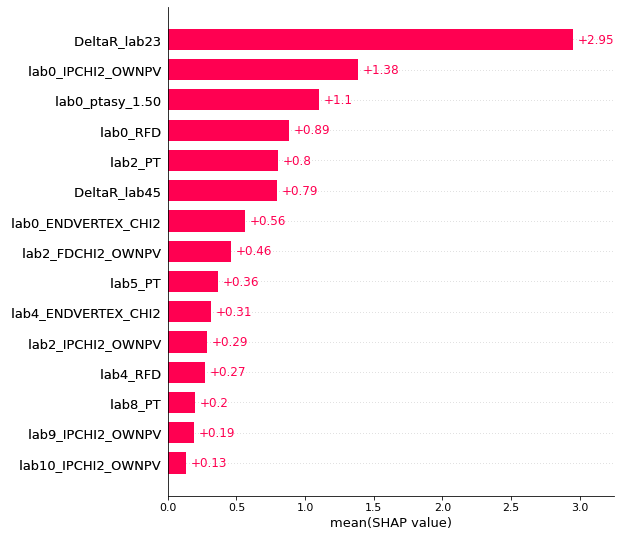

' Lepsze od xgb.plot_importance bo ta funkcja zlicza tylko ile razy została użyta zmienna do decyzji'

In [7]:
# summarize the effects of all the features (bar plot)
shap.summary_plot(shap_values, X, plot_type="bar")
# global feature importance plot
shap.plots.bar(explainer(X), max_display=20)
""" Lepsze od xgb.plot_importance bo ta funkcja zlicza tylko ile razy została użyta zmienna do decyzji"""

In [8]:
# Importance difference plot
# shap_importance = dict(zip(feature_names, abs(shap_values).mean(axis=0)))
# xgb_importance = booster.get_score(importance_type="total_cover")

# shap_rank = {feature_name: rank for rank, feature_name in enumerate(sorted(shap_importance, key=shap_importance.get, reverse=True), 1)}
# xgb_rank = {feature_name: rank for rank, feature_name in enumerate(sorted(xgb_importance, key=xgb_importance.get, reverse=True), 1)}
# feature_rank = [[feature, xgb_rank[feature], shap_rank[feature]] for feature in feature_names]

# df = pd.DataFrame(feature_rank, columns=["feature", "xgb", "shap"])

# # draw line
# def newline(p1, p2, color='black'):
#     ax = plt.gca()
#     l = mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], color='red' if p2[1]-p1[1] > 0 else 'green', marker='o', markersize=6)
#     ax.add_line(l)
#     return l

# fig, ax = plt.subplots(1,1,figsize=(14,14), dpi= 80)

# # Vertical Lines
# ax.vlines(x=1, ymin=0, ymax=16, color='black', alpha=0.7, linewidth=1, linestyles='dotted')
# ax.vlines(x=3, ymin=0, ymax=16, color='black', alpha=0.7, linewidth=1, linestyles='dotted')

# # Points
# ax.scatter(y=df['xgb'], x=np.repeat(1, df.shape[0]), s=10, color='black', alpha=0.7)
# ax.scatter(y=df['shap'], x=np.repeat(3, df.shape[0]), s=10, color='black', alpha=0.7)

# # Line Segmentsand Annotation
# for p1, p2, c in zip(df['xgb'], df['shap'], df['feature']):
#     newline([1,p1], [3,p2])
#     ax.text(1-0.05, p1, c + ', ' + str(round(p1)), horizontalalignment='right', verticalalignment='center', fontdict={'size':14})
#     ax.text(3+0.05, p2, c + ', ' + str(round(p2)), horizontalalignment='left', verticalalignment='center', fontdict={'size':14})

# # 'Before' and 'After' Annotations
# ax.text(1-0.05, 0, 'XGB', horizontalalignment='right', verticalalignment='center', fontdict={'size':18, 'weight':700})
# ax.text(3+0.05, 0, 'SHAP', horizontalalignment='left', verticalalignment='center', fontdict={'size':18, 'weight':700})

# # Decoration
# ax.set_title("Feature Importance Ranking", fontdict={'size':22})
# ax.set(xlim=(0,4), ylim=(0,16), ylabel='Feature Importance')
# # ax.set_xticks([1,3])
# # ax.set_xticklabels(["XGB", "SHAP"])
# # plt.yticks(np.arange(0, 16, 1), fontsize=12)

# # Lighten borders
# plt.gca().spines["top"].set_alpha(.0)
# plt.gca().spines["bottom"].set_alpha(.0)
# plt.gca().spines["right"].set_alpha(.0)
# plt.gca().spines["left"].set_alpha(.0)
# plt.gca().invert_yaxis()

# plt.axis("off")
# plt.show()

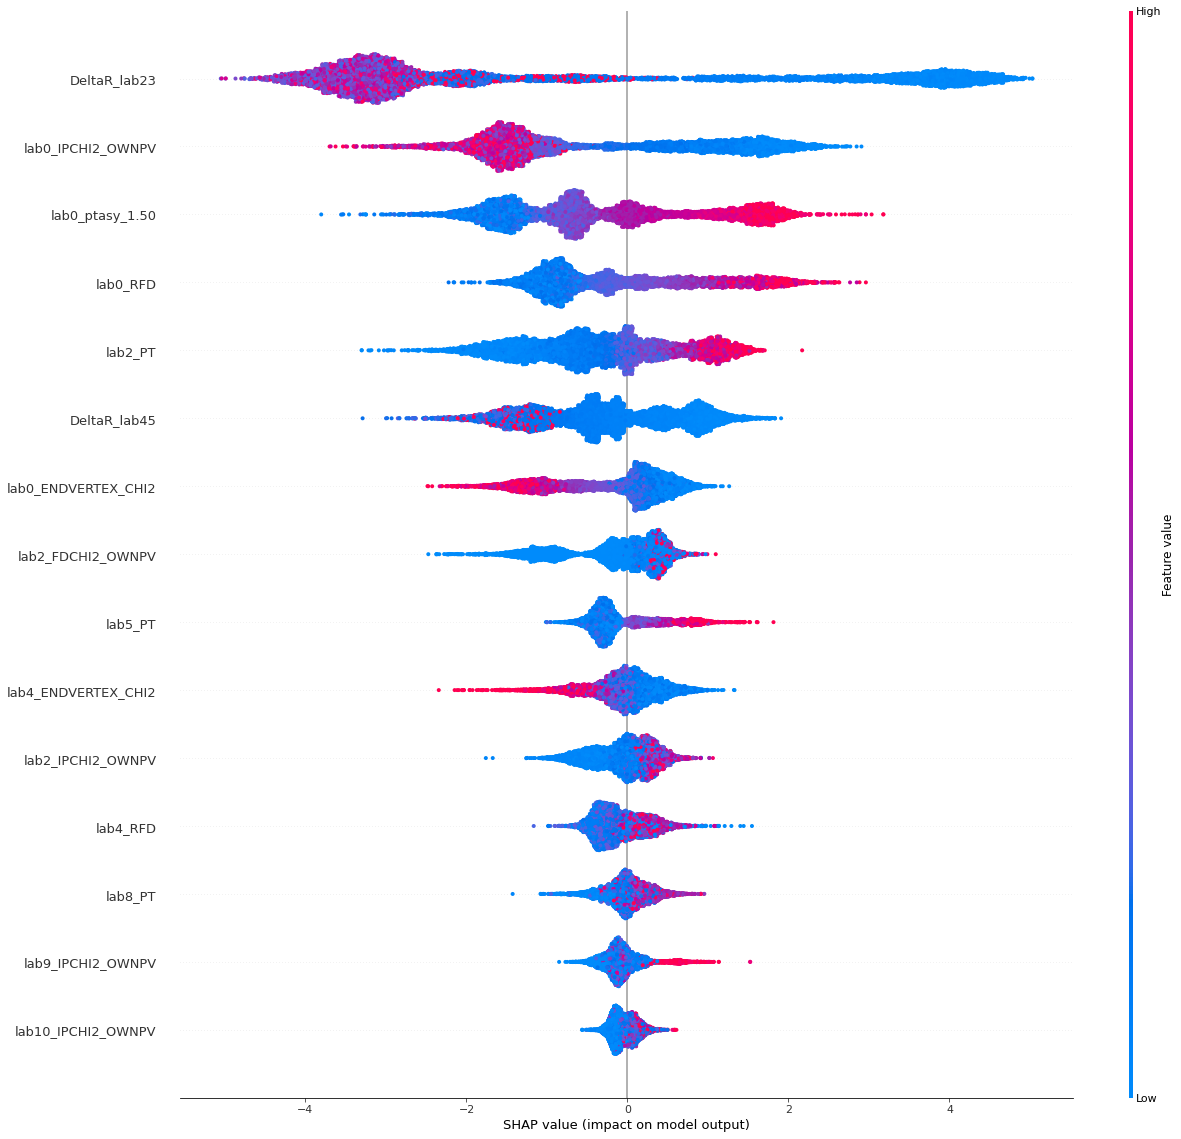

"\nWykres sumaryczny uwzględnia wszystkie cechy użyte w modelu. Prezentowane ponizej cechy są posortowane według\nwartości bezwzględnej ich wpływu na predykcje modelu. Cecha o największym wpływie na model to 'DeltaR_lab23', a ta\no najmniejszym wpływie na model to 'lab10_IPCHI2_OWNPV'. Ponadto patrząc na przykład na cechę 'DeltaR_lab23'\nmożna zauważyć, że niskie wartości tej cechy (niebieski kolor) mocno wpływają na zaklasyfikowanie próby jako sygnał.\n"

In [9]:
# summarize the effects of all the features (beeswarm plot)
shap.summary_plot(shap_values, X, plot_size=(20, 20))
#shap.summary_plot(shap_values[:,1:2], X.iloc[:,1:2], color_bar=False, plot_size=(20, 20))
"""
Wykres sumaryczny uwzględnia wszystkie cechy użyte w modelu. Prezentowane ponizej cechy są posortowane według
wartości bezwzględnej ich wpływu na predykcje modelu. Cecha o największym wpływie na model to 'DeltaR_lab23', a ta
o najmniejszym wpływie na model to 'lab10_IPCHI2_OWNPV'. Ponadto patrząc na przykład na cechę 'DeltaR_lab23'
można zauważyć, że niskie wartości tej cechy (niebieski kolor) mocno wpływają na zaklasyfikowanie próby jako sygnał.
"""

In [10]:
# calculate interactions
data_matrix = prepare_data_matrix(data, feature_names)
interaction = explainer.shap_interaction_values(data_matrix)

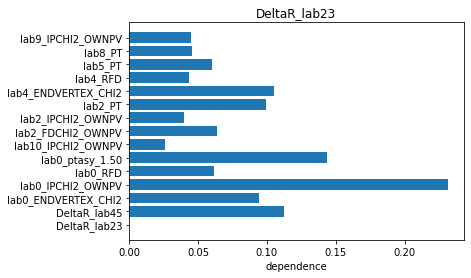

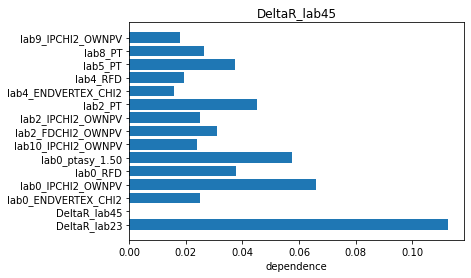

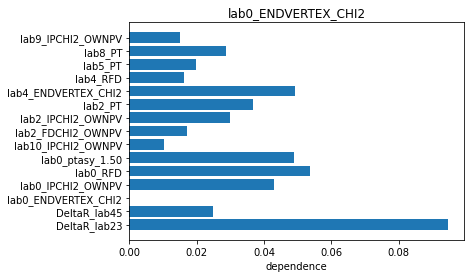

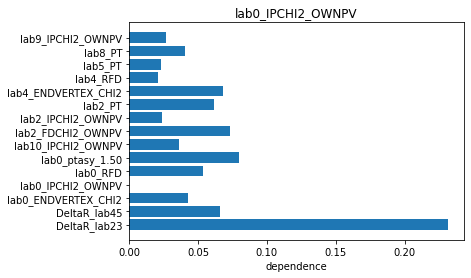

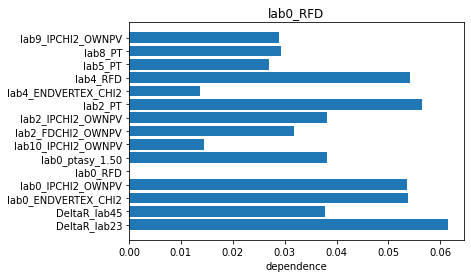

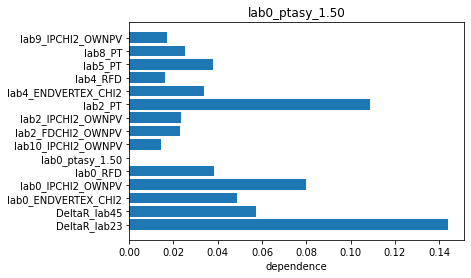

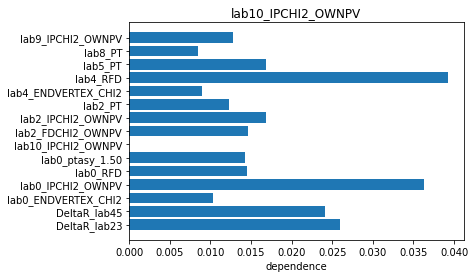

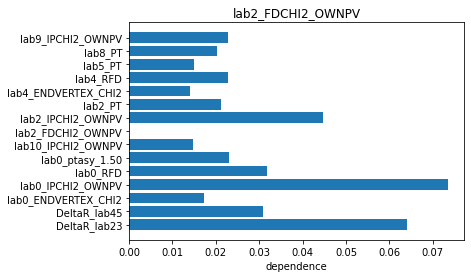

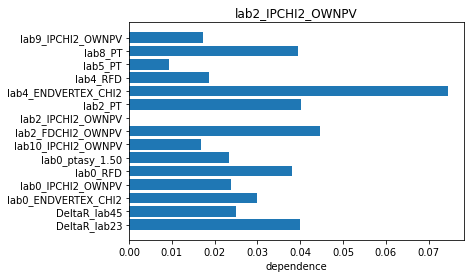

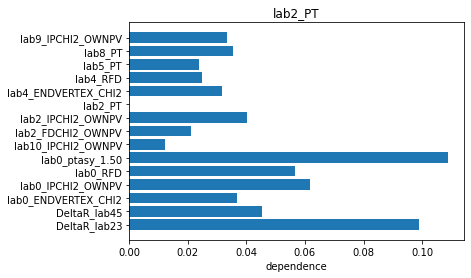

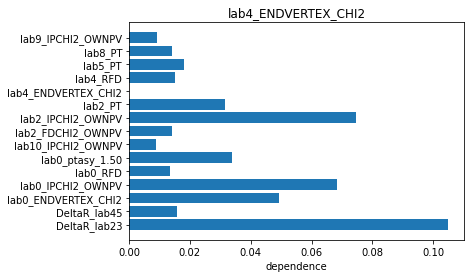

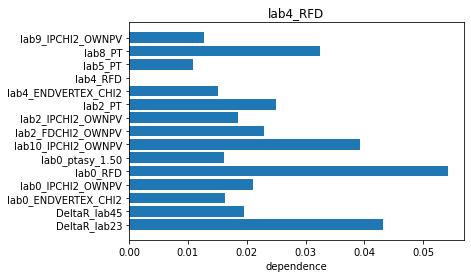

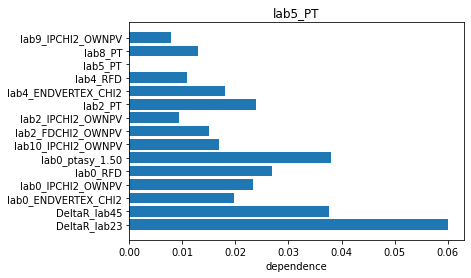

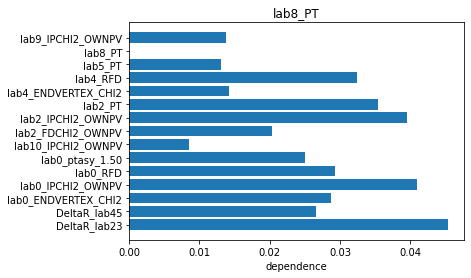

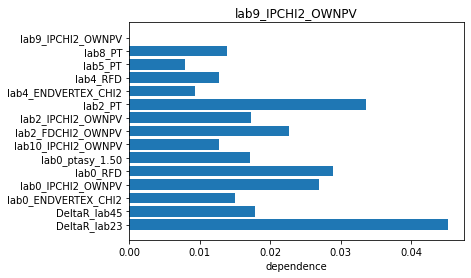

In [11]:
for idx, feature in enumerate(feature_names):
    plt.figure()
    dependence = np.mean(np.abs(interaction[:,idx]), axis=0)
    dependence[idx] = 0
#     dependence = [v for i, v in enumerate(all_dependence) if i !=idx]
    fn = feature_names[:]
#     fn.remove(feature)
    plt.barh(fn, dependence)
    plt.title(feature)
    plt.xlabel("dependence")
#     plt.xlim([0, 0.25])
    
#     max_feature_idx = np.argmax(dependence)
#     max_feature = feature_names[max_feature_idx]
#     shap_max_feature_idx = shap.utils.approximate_interactions(feature, shap_values, X, feature_names=feature_names)[0]
#     shap_max_feature = feature_names[shap_max_feature_idx]
#     if max_feature != shap_max_feature:
#         print(f"{feature}:\t{max_feature}\t{shap_max_feature}")
#         print(f"{(dependence[max_feature_idx] - dependence[shap_max_feature_idx]) / dependence[max_feature_idx]:.2}")

[6, 14, 12, 11, 13, 7, 8, 10, 2, 4, 1, 9, 5, 3, 0]


Text(0.5, 0, 'dependence')

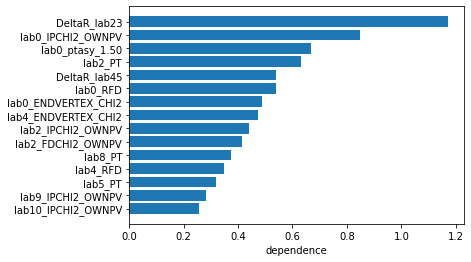

In [12]:
# Total interaction values

all_dependence = np.empty(15)
for idx, feature in enumerate(feature_names):
    dependence = np.mean(np.abs(interaction[:,idx]), axis=0)
    dependence[idx] = 0
    all_dependence = np.add(all_dependence, dependence)
    fn = feature_names[:]

print(np.argsort(all_dependence).tolist())
sorted_features = [ feature_names[i] for i in np.argsort(all_dependence) ]
plt.barh(sorted_features, sorted(all_dependence))
plt.xlabel("dependence")

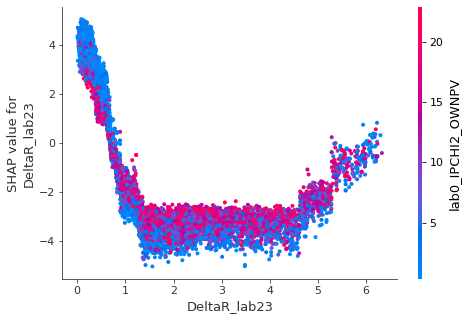

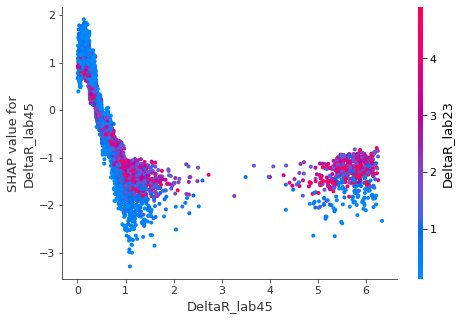

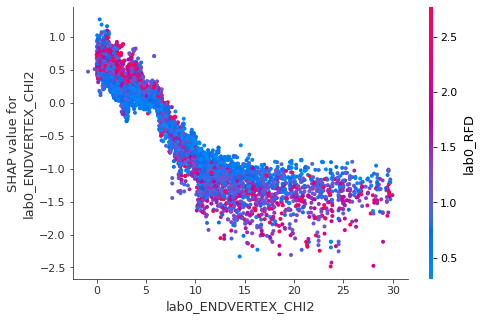

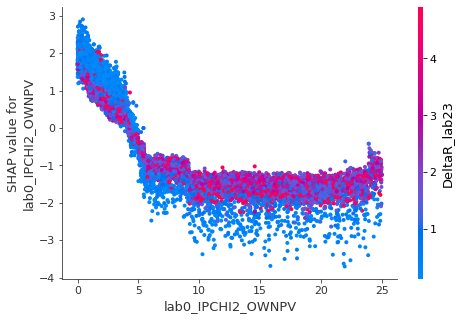

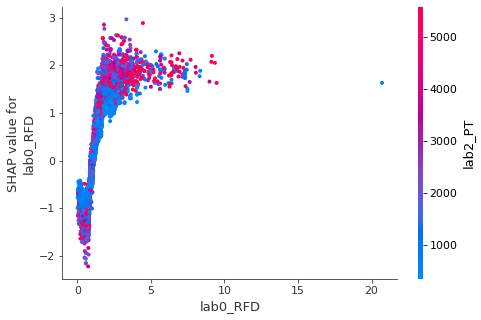

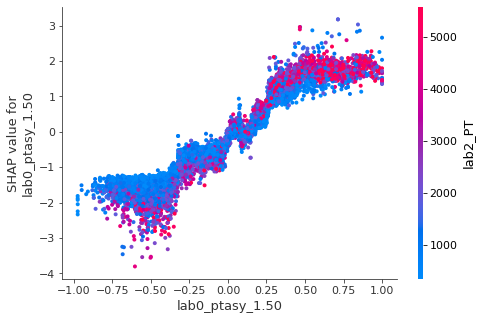

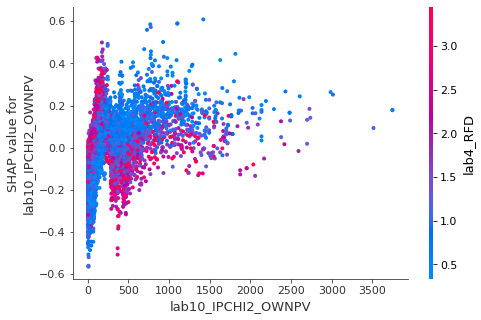

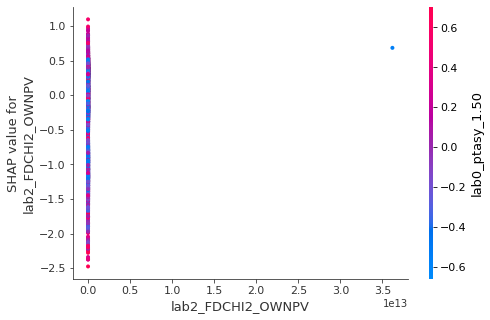

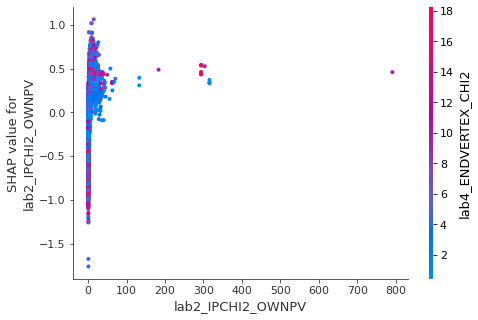

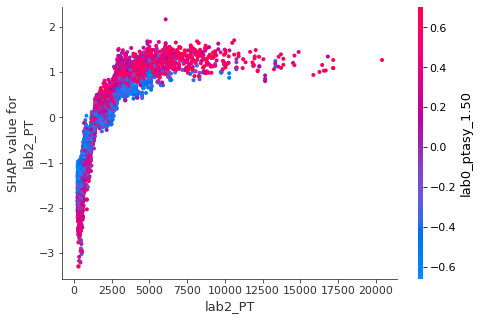

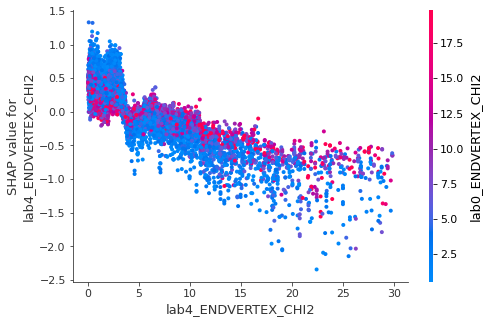

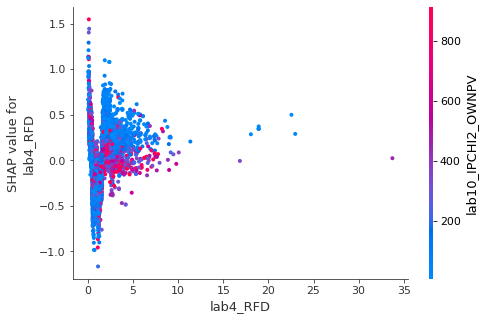

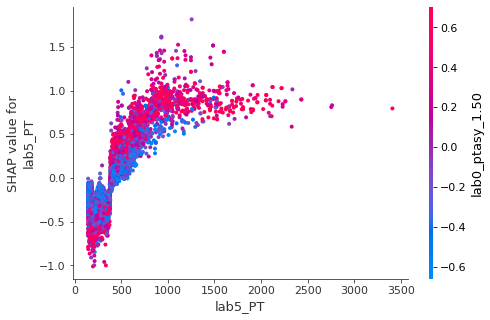

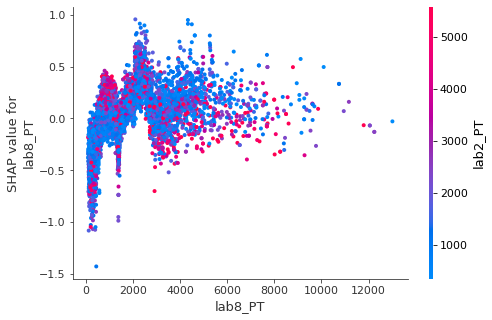

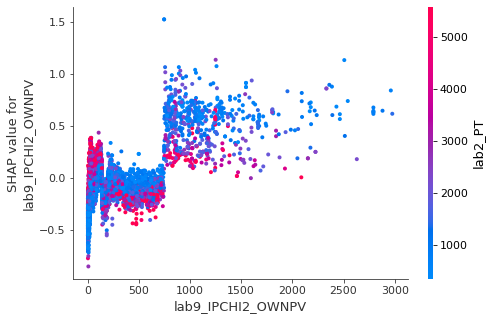

In [13]:
# dependence plots - 15*14=210 plots but we don't care if there is no feature interaction
# the second feature (color) is chosen automatically by shap.common.approximate_interactions
for feature in feature_names:
    shap.dependence_plot(feature, shap_values, X,)

In [14]:
# Dependence plots but also with logarithmic scale

# for idx, feature in enumerate(feature_names[0:3]):
#     print(feature)
#     max_feature_idx = shap.utils.approximate_interactions(feature, shap_values, X, feature_names=feature_names)[13]
#     max_feature = feature_names[max_feature_idx]
#     sv = shap_values[:,idx]
#     fv = X[feature]
#     fv2 = X[max_feature].to_numpy()
#     vmin = np.nanpercentile(X[max_feature], 5)
#     vmax = np.nanpercentile(X[max_feature], 95)
#     fv2[fv2 > vmax] = vmax
#     fv2[fv2 < vmin] = vmin
#     if vmin == vmax:
#         print(f"Invalid colorbar ranges {feature}")
    
#     # Linear x axis
#     fig1 = plt.figure()
#     plt.scatter(fv, sv, s=6, c=fv2, cmap=shap.plots.colors.red_blue, vmin=vmin, vmax=vmax)
#     cbar1 = plt.colorbar()
#     cbar1.set_label(f"{max_feature}")
#     plt.xlabel(feature)
#     plt.ylabel(f"SHAP value for \n{feature}")
#         #     plt.show()
# #     file_name1 = f"img/shap_dependence/shap_dependence_{feature}.png"
# #     plt.savefig(file_name1)
# #     plt.close(fig1)
    
#     # Logarithmic x axis
#     fig2 = plt.figure()
#     plt.scatter(fv, sv, s=6, c=fv2, cmap=shap.plots.colors.red_blue, vmin=vmin, vmax=vmax)
#     cbar2 = plt.colorbar()
#     cbar2.set_label(f"{max_feature}")
#     plt.xlabel(feature)
#     plt.ylabel(f"SHAP value for \n{feature}")
#     plt.xscale("log")
#     #     plt.show()
# #     file_name2 = f"img/shap_dependence/shap_dependence_{feature}_log.png"
# #     plt.savefig(file_name2)
# #     plt.close(fig2)

In [15]:
# latex_1 = r"""\begin{figure}[ht]
#     \centering
#     \begin{subfigure}{0.49\textwidth}
#             \includegraphics[width=\textwidth]"""
# latex_2 = r"""
#     \end{subfigure}
#     \begin{subfigure}{0.49\textwidth}
#         \includegraphics[width=\textwidth]"""
# latex_3 = r"""
#     \end{subfigure}
# \end{figure}"""

# for feature in feature_names:
#     file_string1 = f"{{img/shap_dependence/shap_dependence_{feature}.png}}"
#     file_string2 = f"{{img/shap_dependence/shap_dependence_{feature}_log.png}}"
#     latex_figures = latex_1 + file_string1 + latex_2 + file_string2 + latex_3 + "\n"
#     print(latex_figures)

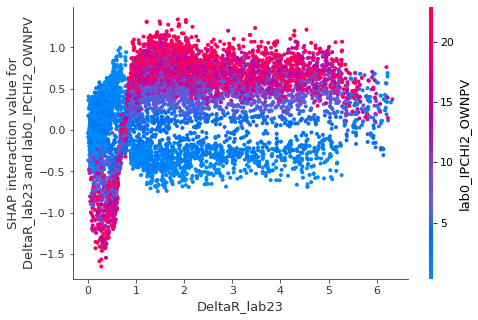

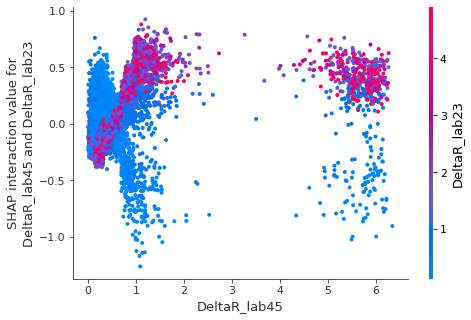

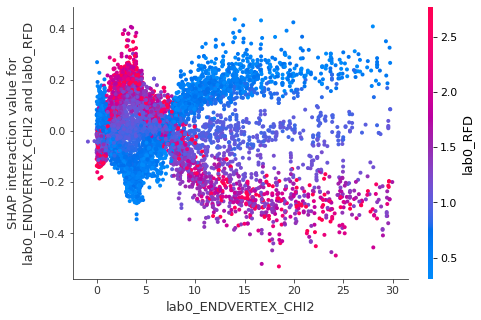

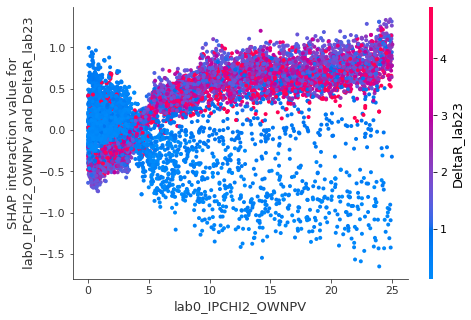

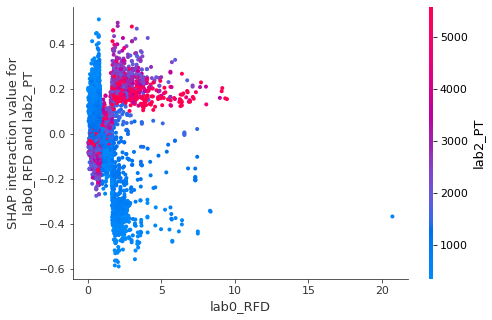

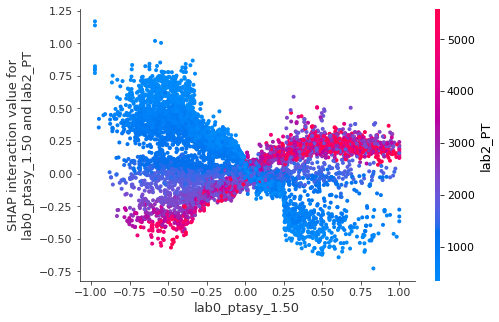

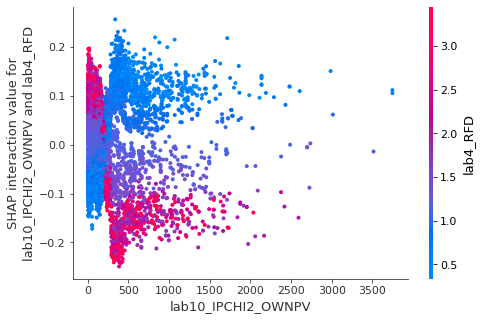

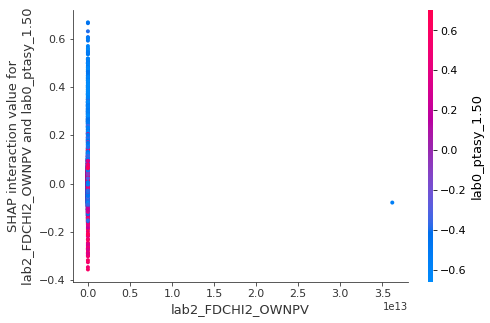

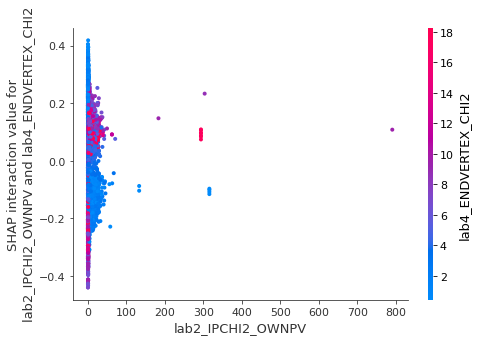

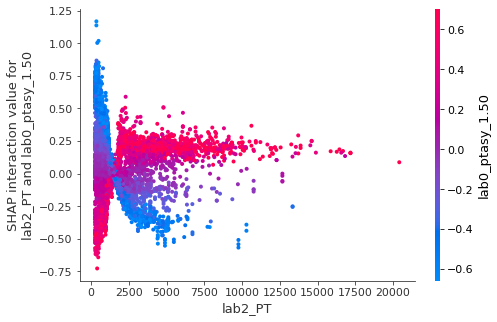

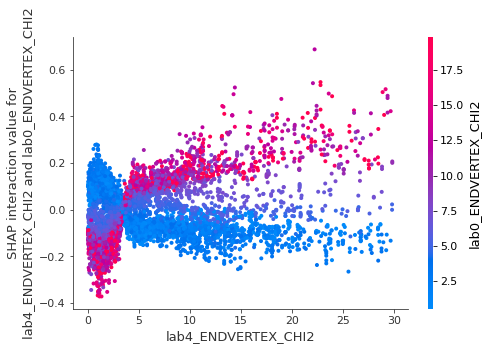

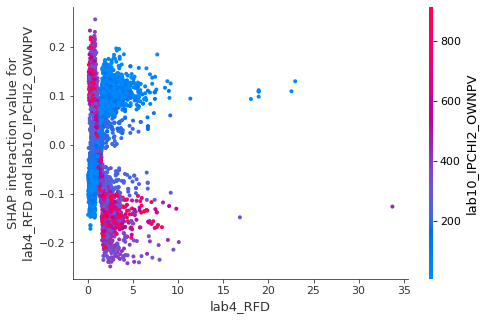

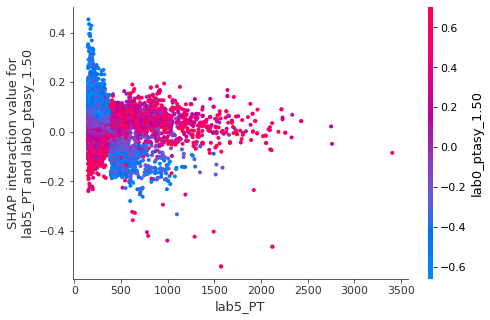

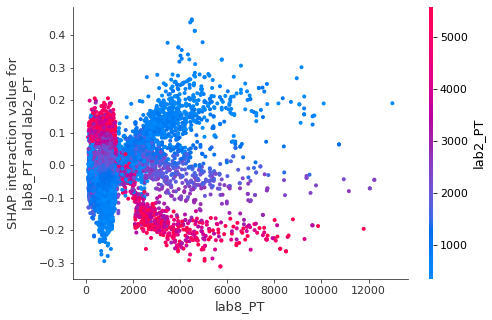

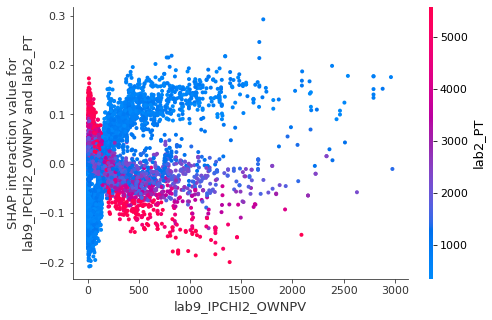

In [16]:
# plot interaction between features
# pretty interesting
for feature in feature_names:
    max_feature_idx = shap.utils.approximate_interactions(feature, shap_values, X, feature_names=feature_names)[0]
    max_feature = feature_names[max_feature_idx]
    shap.dependence_plot((feature, max_feature), interaction, X)

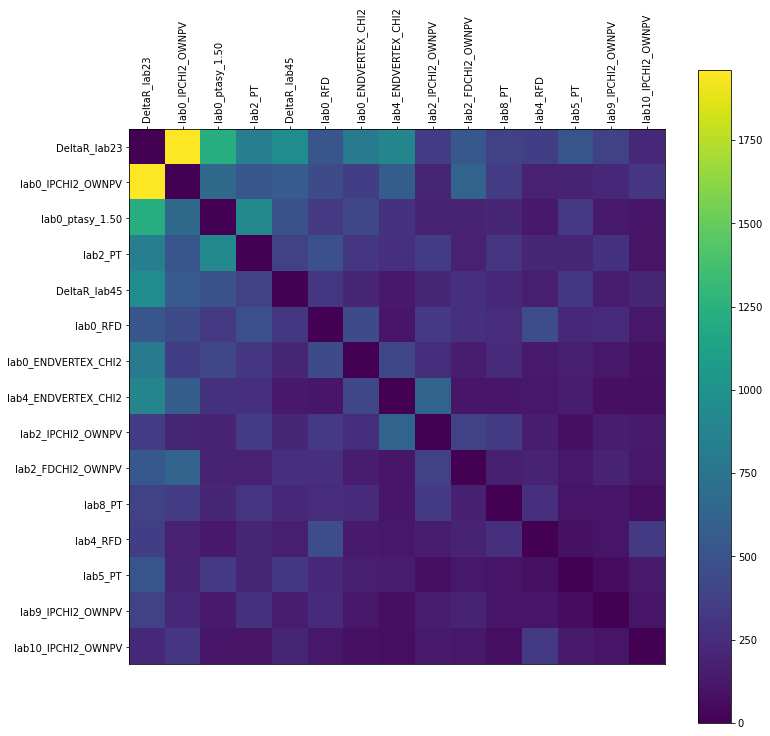

In [17]:
# Interaction matrix

tmp = np.abs(interaction).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds,:][:,inds]
plt.figure(figsize=(12,12))
plt.imshow(tmp2)
plt.yticks(range(tmp2.shape[0]), X.columns[inds],  horizontalalignment="right")
plt.xticks(range(tmp2.shape[0]), X.columns[inds],  rotation=90)
plt.gca().xaxis.tick_top()
plt.colorbar()
plt.show()

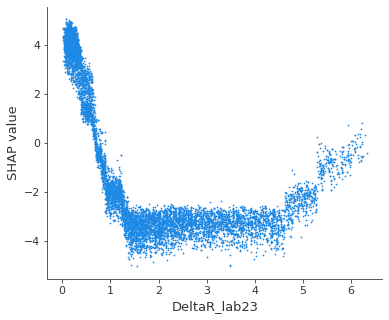

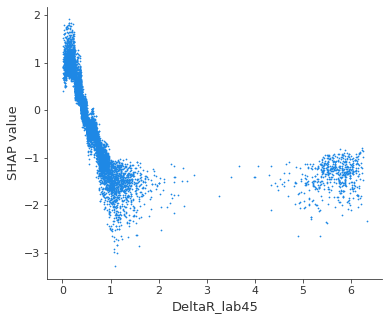

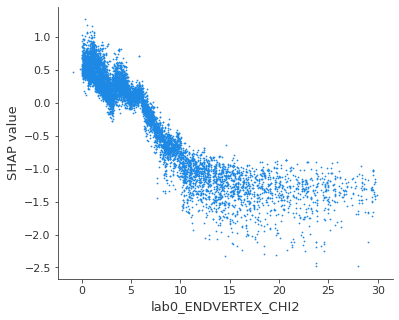

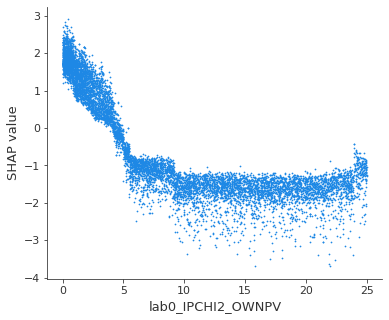

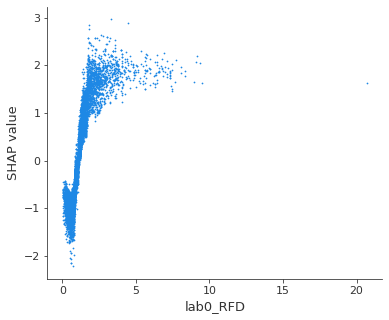

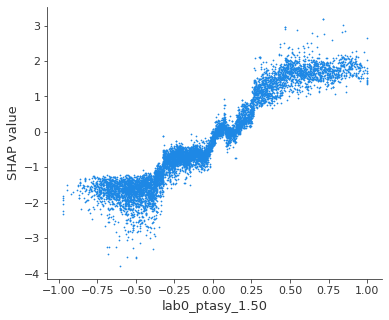

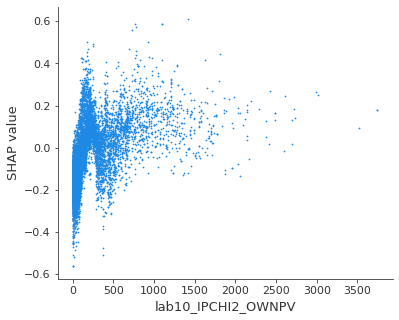

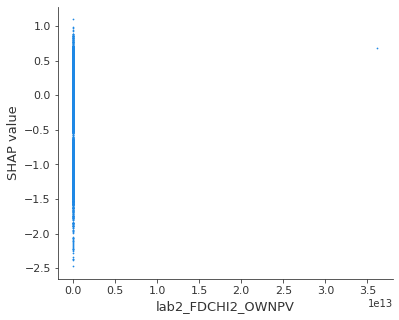

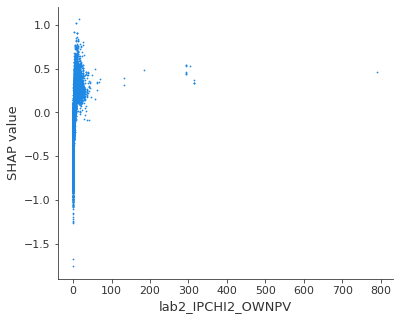

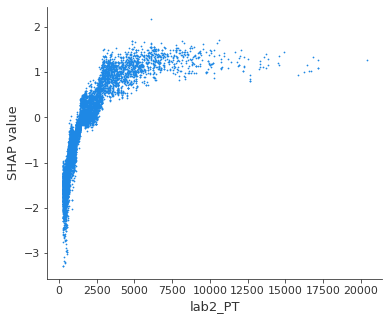

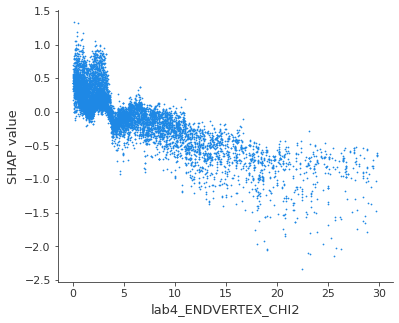

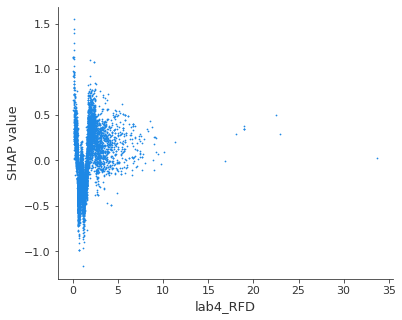

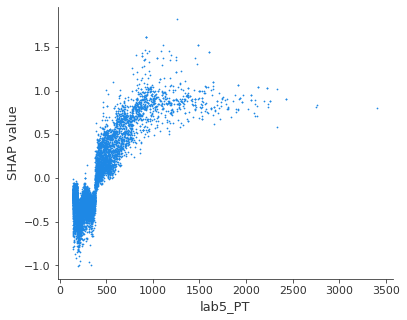

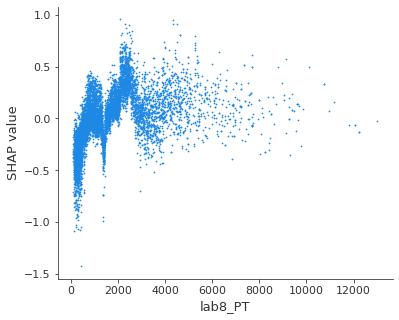

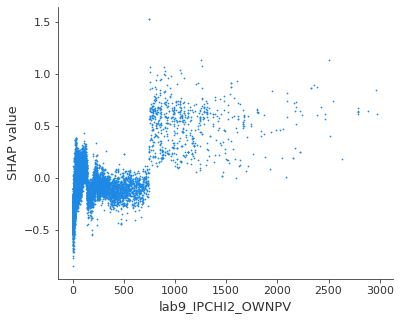

In [18]:
# Bez interakcji, tylko wpływ cechy na predykcje modelu

for feature_name in feature_names:
    shap.dependence_plot(feature_name, shap_values, X, dot_size=3, interaction_index=None, show=False)
    plt.ylabel("SHAP value")
    plt.show()

In [19]:
# Bez interakcji, tylko wpływ cechy na predykcje modelu
# Dodatkowo zaznaczone sygnał i tło.

# handles = [
#     mlines.Line2D([0], [0], marker='o', color='w', label='Scatter', markerfacecolor='g', markersize=10),
#     mlines.Line2D([0], [0], marker='o', color='w', label='Scatter', markerfacecolor='lightgray', markersize=10),
# ]
# colors = [ "green" if label == 's' else "lightgray" for label in data.Label ]

# for idx, feature in enumerate(feature_names):
#     print(feature)
#     fig1 = plt.figure()
#     sv = shap_values[:,idx]
#     fv = X[feature]    
#     plt.scatter(fv, sv, s=2, c=colors)
#     plt.xlabel(feature)
#     plt.ylabel("SHAP value")
#     plt.legend(handles, ["signal", "background"])
# #   if feature in ["lab2_FDCHI2_OWNPV", "lab2_IPCHI2_OWNPV"]:
# #        plt.xscale("log")
# #     plt.show()
#     file_name1 = f"img/shap/shap_{feature}.png"
#     plt.savefig(file_name1)
#     plt.close(fig1)
    
#     fig2 = plt.figure()
#     plt.scatter(fv, sv, s=2, c=colors)
#     plt.xlabel(feature)
#     plt.ylabel("SHAP value")
#     plt.legend(handles, ["signal", "background"])
#     plt.xscale("log")
# #     plt.show()
#     file_name2 = f"img/shap/shap_{feature}_log.png"
#     plt.savefig(file_name2)
#     plt.close(fig2)

    


In [20]:
# latex_1 = r"""\begin{figure}[ht]
#     \centering
#     \begin{subfigure}{0.49\textwidth}
#             \includegraphics[width=\textwidth]"""
# latex_2 = r"""
#     \end{subfigure}
#     \begin{subfigure}{0.49\textwidth}
#         \includegraphics[width=\textwidth]"""
# latex_3 = r"""
#     \end{subfigure}
# \end{figure}"""

# for feature in feature_names:
#     file_string1 = f"{{img/shap/shap_{feature}.png}}"
#     file_string2 = f"{{img/shap/shap_{feature}_log.png}}"
#     latex_figures = latex_1 + file_string1 + latex_2 + file_string2 + latex_3 + "\n"
#     print(latex_figures)

In [21]:
# Zoom into features
# %matplotlib notebook
# handles = [
#     mlines.Line2D([0], [0], marker='o', color='w', label='Scatter', markerfacecolor='g', markersize=10),
#     mlines.Line2D([0], [0], marker='o', color='w', label='Scatter', markerfacecolor='lightgray', markersize=10),
# ]
# colors = [ "green" if label == 's' else "lightgray" for label in data.Label ]
# for idx, feature in enumerate(feature_names):
#     if feature != "lab9_IPCHI2_OWNPV":
#         continue
#     print(feature)
#     print(idx)
#     fig1 = plt.figure()
#     sv = shap_values[:,idx]
#     fv = X[feature]    
#     plt.scatter(fv, sv, s=2, c=colors)
# #     plt.xlim([0,3])
#     plt.grid()
#     plt.xlabel(feature)
#     plt.ylabel("SHAP value")
#     plt.legend(handles, ["signal", "background"])
#     plt.show()

In [22]:
# Wizualizacja wpływu wszystkich cech na wiele prób (tutaj 100)
# można zaobserwować klasteryzacje
# raczej niepotrzebne

# samples = 400
# shap.force_plot(explainer.expected_value, shap_values[0:samples], X.iloc[0:samples])